# Postsecondary School Enrollment Forecast (Institution Level)

NCES publishes its school enrollment data every year here: https://nces.ed.gov/ipeds/datacenter/

However, the latest you data can find is always 1 year behind, in order to get the latest estimate, below shows my implementation using ARIMA to forecast current and next year's enrollment number.

NCES has forecast on national level and few demographic attribute, however, there's no state level forecast. 

This is a follow up from the state level forecast. Now we wanted to see if there's a way to forecast institutional level enrollment.

## I am going to try 2 approaches:

1. Use the state level forecast and weight the one year and two year ahead forecast by $w_i^s$ as defined here:
$$
\begin{align}
w_i^c &= \frac {\displaystyle \sum_{y \in year} count_{y, i}} {\displaystyle \sum_{y \in year} \displaystyle \sum_{i_s \in inst \forall s \in state} count_{y, i_s}}\\
\text {where i }&\text{ = institute}\\
\text {year }&\text{ = [1991,2014] (actual enrollment data available)}\\
\end{align}
$$
This approach doesn't work, might need a different weight factor.
2. Cluster-Trend-Forecast [(see details below)](#Approach-2)

## Approach 1

### 1. Read State Level Forecast 
[See how I forecasted state level enrollment.]({{ site.url }}/2015/12/08/college-enrollment-forecast-state-level.html)

In [1]:
# load package
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from statsmodels import api as sm
import numpy as np
import pickle
# load mpld3 for drawing
import mpld3
mpld3.enable_notebook()

%autoreload 1
%aimport vaildation_mod

# turn off warning
import warnings
warnings.filterwarnings('ignore')

# Load the institution info
intinfo = pd.read_excel('DATA_SOURCE\ENROLLMENT_FORECAST_DS.xlsx', sheetname='INST_CHAR')
lab = pd.read_excel('DATA_SOURCE\ENROLLMENT_FORECAST_DS.xlsx', sheetname='INST_CHAR_COLUMNS')
# Load Data
enrollment = pd.read_excel('DATA_SOURCE\ENROLLMENT_FORECAST_DS.xlsx', sheetname='EnrollmentByInstitution')
inst_state = pd.read_excel('DATA_SOURCE\ENROLLMENT_FORECAST_DS.xlsx', sheetname='Institution')
state_level_forecast = pd.read_excel('DATA_SOURCE\ENROLLMENT_FORECAST_DS.xlsx', sheetname='STATE_FORECAST_1516')

inst_state.columns = ['UnitId', 'Name', 'City', 'State']
enrollment = enrollment.merge(inst_state.drop('Name', axis = 1))
enrollment = enrollment.replace('-', 0)

schools = enrollment[['UnitId', 'Institution Name']]

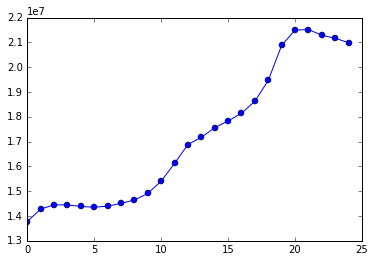

In [2]:
# overall trend
plt.plot(np.sum(enrollment.iloc[:,2:-2]).values, '-o');

### 2. Calculate $w_i^s$

In [3]:
# total school enrollment
er1 = enrollment.copy()
er1['total_school_enrollment'] = np.sum(er1.drop(['UnitId', 'Institution Name', 'City', 'State'], axis = 1), axis = 1)

# count per state
state_sum = pd.DataFrame(np.sum(state_level_forecast.drop([2015,2016], axis = 1), axis = 1))
state_sum.columns = ['state_sum']
state_sum['State'] = state_sum.index
er1 = er1.merge(state_sum)

# calculate wis as defined above
er1['wis'] = er1.total_school_enrollment/er1.state_sum
# preview
er1.head()

,UnitId,Institution Name,Fall 1990,Fall 1991,Fall 1992,Fall 1993,Fall 1994,Fall 1995,Fall 1996,Fall 1997,...,Fall 2010,Fall 2011,Fall 2012,Fall 2013,Fall 2014,City,State,total_school_enrollment,state_sum,wis
0,100654,Alabama A & M University,4886,5215,5068,5593,5543,5400,5263,5094,...,5814,4922,4853,5020,5333,Normal,AL,137241,6076520,0.022585
1,100663,University of Alabama at Birmingham,15356,15922,15735,15913,15362,15502,15274,14933,...,17543,17575,17999,18568,18698,Birmingham,AL,405211,6076520,0.066685
2,100690,Amridge University,104,107,106,144,140,183,182,240,...,749,775,703,631,625,Montgomery,AL,11452,6076520,0.001885
3,100706,University of Alabama in Huntsville,8139,8624,8026,8232,7492,7218,6713,6464,...,7614,7629,7636,7376,7348,Huntsville,AL,183383,6076520,0.030179
4,100724,Alabama State University,4587,4822,5488,5608,5037,5416,5552,5273,...,5705,5425,5816,6075,5519,Montgomery,AL,138014,6076520,0.022713


In [4]:
# MAPE with real 13, 14 enrollment
# Note: more logical step would be forecasting them and validate them, but here's just for a quick check

# calculate forecast by real data

def times_wis(x, yr):
    return state_level_forecast.ix[x.State, yr] * x.wis

er1['fall_2013_w'] = er1.apply(lambda x: times_wis(x, 2013), axis = 1)
er1['fall_2014_w'] = er1.apply(lambda x: times_wis(x, 2014), axis = 1)

# calculate mape
print('MAPE of 2013', sum(er1['fall_2013_w']-er1['Fall 2013'])/er1.shape[0])
print('MAPE of 2014', sum(er1['fall_2014_w']-er1['Fall 2014'])/er1.shape[0])

MAPE of 2013 90.8809816965
MAPE of 2014 90.0824075709


Ok... so probably this is not the best approach.

## Approach 2

### 1. Scale and cluster

It's possible to do more processing and get different result, but we shall see which makes more sense. 

* See partition and group approach here: http://hanj.cs.illinois.edu/pdf/sigmod07_jglee.pdf

#### 1. Scale
1. Scale to the entire row vector to [0,1] range
2. Rebase (pick a year) to 0

#### 2. Culster
1. Cluster based on the n previous period
2. Use either gmm or kmeans
   <br>Very good reference on GMM (EM - Gaussian): http://www.nature.com/nbt/journal/v26/n8/full/nbt1406.html
   <br>If using gmm, since we don't have concers for high dimensions, it'll use full covariance matrix. See what that means here: http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note08-2up.pdf
3. Generate n cluster solution

#### 3. Forecast
1. Produce aggregate forecast result
2. Disaggregate forecast result using weight similar to the definition above but substitute the state by cluster

In [5]:
# prepare a matrix to cluster
er2 = enrollment.copy()
er2 = er2.transpose()
er2.columns = er2.ix['UnitId']
er2.drop(['UnitId', 'Institution Name', 'City', 'State'], inplace = True)
er2.index = [pd.Period(x) for x in range(1990,2015)]
er2.tail(5)

UnitId,100654,100663,100690,100706,100724,100733,100751,100760,100812,100830,...,485306,485342,485351,485379,485388,485397,485412,485421,485458,485467
2010,5814,17543,749,7614,5705,0,30127,2447,3621,5817,...,0,0,0,0,0,0,0,0,0,0
2011,4922,17575,775,7629,5425,0,31647,2451,3389,5305,...,0,0,0,0,0,0,0,0,0,0
2012,4853,17999,703,7636,5816,0,33503,2021,3415,5005,...,0,0,0,0,0,0,0,0,0,0
2013,5020,18568,631,7376,6075,0,34752,1906,3170,5084,...,0,0,0,0,0,0,0,0,0,0
2014,5333,18698,625,7348,5519,0,36047,1726,3128,5057,...,53,181,461,55,75,113,67,94,2431,0


In [6]:
def how_many_zeros(x):
    return sum(x == 0)

# Filter out those with less than 100 enrollment in the past
er2 = er2.ix[:, np.sum(er2, axis = 0) > 100]

# Filter out those with no data in the past 5 years
er2 = er2.ix[:,er2.tail(3).apply(lambda x: how_many_zeros(x))==0]

# filtered 7682-6970 = 1124 rows
er2.shape

(25, 6970)

In [7]:
# validation module pipline the process and paramatize important variables.
# demo
demo = vaildation_mod.predict_by_cluster(er2)

WMAPE on Cluster
WMAPE of 2013 = 0.020565
WMAPE of 2014 = 0.038220
WMAPE on Institution
WMAPE of 2013 = 0.074574
WMAPE of 2014 = 0.106712


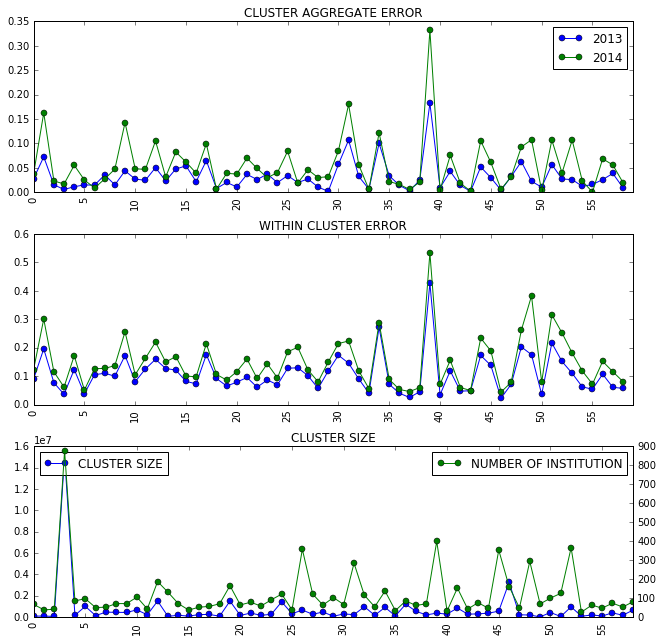

In [8]:
demo.draw_cluster_error()

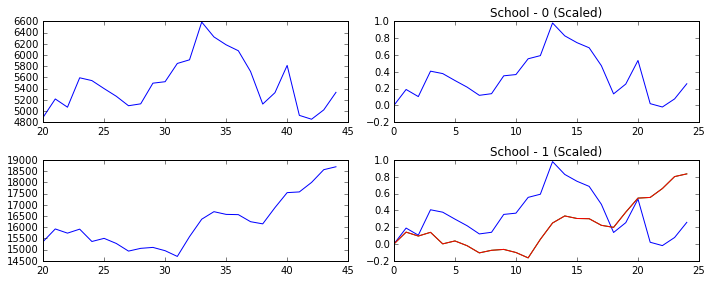

In [9]:
# see what did scaling do
demo.draw_trend(0,1)

Notice that relatively, there's no change to the trend, just that now it's possible to compare different trend.

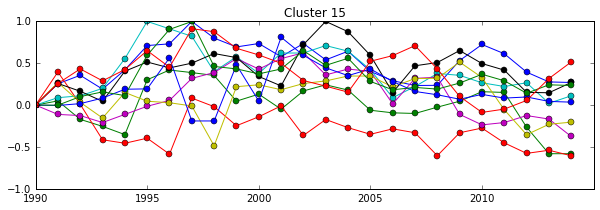

In [10]:
# see what cluster does
demo.draw_cluster_trend(15, 10, schools)

The last n period trend are similar

In [11]:
# change clustering algo (kmeans) with large n?
# conceptually, it should be more predictive, but it's not
# worse than GMM but similar to kmeans on n_clusters = default
p_km = vaildation_mod.predict_by_cluster(er2, cluster_method = 'kmeans')

WMAPE on Cluster
WMAPE of 2013 = 0.024972
WMAPE of 2014 = 0.043780
WMAPE on Institution
WMAPE of 2013 = 0.082462
WMAPE of 2014 = 0.114252


In [12]:
# different base?
p_n = vaildation_mod.predict_by_cluster(er2, rebase_to_n = 3, cluster_n_period = 20)

WMAPE on Cluster
WMAPE of 2013 = 0.018067
WMAPE of 2014 = 0.036291
WMAPE on Institution
WMAPE of 2013 = 0.071927
WMAPE of 2014 = 0.104767


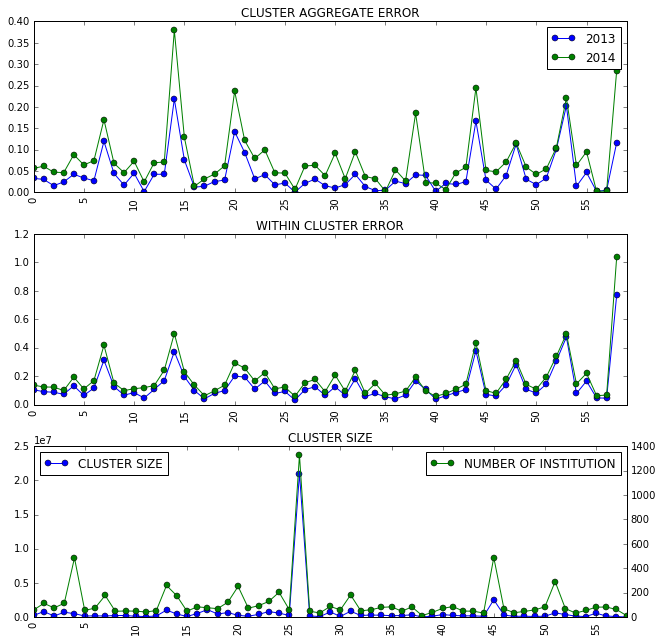

In [13]:
p_n.draw_cluster_error()

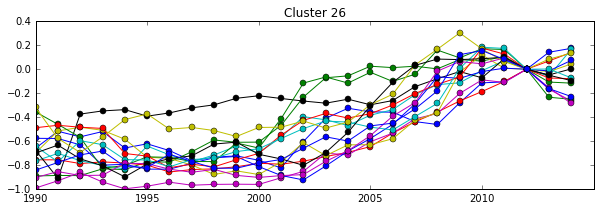

In [14]:
p_n.draw_cluster_trend(26, 15, schools)

##### Adding umemployment

In [15]:
# add umemployment
umemployment = pd.read_excel('DATA_SOURCE\ENROLLMENT_FORECAST_DS.xlsx', sheetname='Unemployment Rate')
umemployment.index = [pd.Period(x) for x in umemployment.Year]
umemployment.drop(['Year'], axis = 1, inplace = True)
umemployment.columns = ['umemployment_rate']

In [16]:
print('umemployment lag0')
exog = umemployment[34:].copy()
p_um0 = vaildation_mod.predict_by_cluster(er2, exog = exog, rebase_to_n = 3, cluster_n_period = 20)
print('umemployment lag0 + lag1')
exog['umemployment_rate_lag1'] = umemployment[33:-1].values
p_um01 = vaildation_mod.predict_by_cluster(er2, exog = exog, rebase_to_n = 3, cluster_n_period = 20)

umemployment lag0
WMAPE on Cluster
WMAPE of 2013 = 0.021534
WMAPE of 2014 = 0.039217
WMAPE on Institution
WMAPE of 2013 = 0.074741
WMAPE of 2014 = 0.106586
umemployment lag0 + lag1
WMAPE on Cluster
WMAPE of 2013 = 0.024189
WMAPE of 2014 = 0.042203
WMAPE on Institution
WMAPE of 2013 = 0.076140
WMAPE of 2014 = 0.107207


##### Adding disposable income

In [17]:
dp = pd.read_excel('DATA_SOURCE\ENROLLMENT_FORECAST_DS.xlsx', sheetname='DISPOSABLE_INCOME')
dp.columns = ['Year', 'DSPI']
dpg = dp.groupby('Year')
dp = dpg.mean().reset_index()
dp.index = [pd.Period(x, freq = 'A') for x in dp.Year]
dp.drop(['Year'], axis = 1, inplace=True)

In [18]:
print('umemployment lag0 + lag1 + dspi lag 5')
exog = umemployment[34:].copy()
exog['umemployment_rate_lag1'] = umemployment[33:-1].values

exog['dspi_lag5'] = dp[26:-6].values
p_um0_ds5 = vaildation_mod.predict_by_cluster(er2, exog = exog, rebase_to_n = 3, cluster_n_period = 20)
print ('umemployment lag0 + lag1 + dspi lag 5 + dspi lag 4')
exog['dspi_lag4'] = dp[27:-5].values
p_um0_ds45 = vaildation_mod.predict_by_cluster(er2, exog = exog, rebase_to_n = 3, cluster_n_period = 20)

umemployment lag0 + lag1 + dspi lag 5
WMAPE on Cluster
WMAPE of 2013 = 0.049708
WMAPE of 2014 = 0.053833
WMAPE on Institution
WMAPE of 2013 = nan
WMAPE of 2014 = nan
umemployment lag0 + lag1 + dspi lag 5 + dspi lag 4
WMAPE on Cluster
WMAPE of 2013 = 0.040126
WMAPE of 2014 = 0.047338
WMAPE on Institution
WMAPE of 2013 = nan
WMAPE of 2014 = nan


## Final Model

In [19]:
exog = umemployment[34:].copy()
exog['umemployment_rate_lag1'] = umemployment[33:-1].values
p = vaildation_mod.predict_by_cluster(er2, exog = None, rebase_to_n = 3, cluster_n_period = 20, hold_out_n=2)

# pickle it, takes a while to run
pickle.dump(p, open('inst_model.p', 'wb'))
# p = pickle.load(open('inst_model.p', 'rb'))

cluster = pd.DataFrame([p.ds.columns, p.ds_c.tolist()])
cluster = cluster.transpose()
cluster.columns = ['UnitID', 'cluster']
ds = cluster.merge(intinfo, how = 'left')

WMAPE on Cluster
WMAPE of 2013 = 0.018067
WMAPE of 2014 = 0.036291
WMAPE on Institution
WMAPE of 2013 = 0.071927
WMAPE of 2014 = 0.104767


### Error Analysis

Where are the errors?

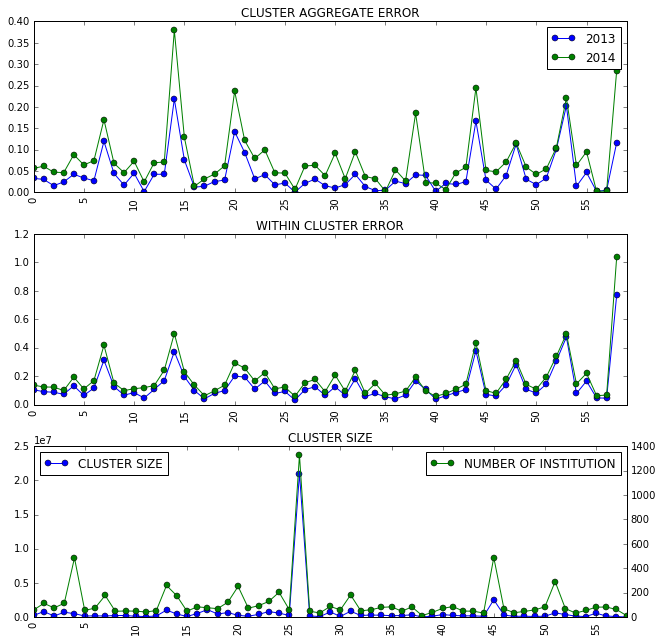

In [20]:
p.draw_cluster_error()

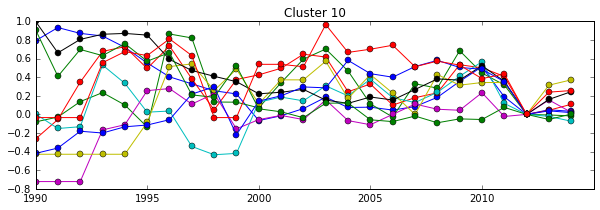

In [21]:
p.draw_cluster_trend(10, 10, schools)

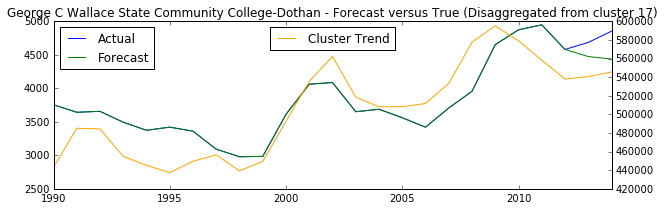

In [22]:
p.look_at_institute(19, inst_name = schools)

In [23]:
# add two more years umemployment projection from FED

umemployment.loc[pd.Period(2015)] = 5.0
umemployment.loc[pd.Period(2016)] = 4.8
# umemployment.tail(2)

In [24]:
# produce the forecast

exog = umemployment[34:].copy()
exog['umemployment_rate_lag1'] = umemployment[33:-1].values

p = vaildation_mod.predict_by_cluster(er2, exog = exog, rebase_to_n = 3, cluster_n_period = 15, hold_out_n = 0)
forecast = p.get_forecast()
forecast.to_csv('institution_forecast.csv')

### Profiling on Cluster on Final Model

This section will used some institution info such as age, gender, institution type (occupational/academic etc.) downloaded from NCES and try to make sense of cluster (or not?).

In [25]:
# variables to profile
for i in range(len(ds.columns)):
    print(i, ds.columns[i])

0 UnitID
1 cluster
2 Institution Name
3 Occupational (IC2014)
4 Academic (IC2014)
5 Continuing professional (IC2014)
6 Recreational or avocational (IC2014)
7 Adult basic remedial or high school equivalent (IC2014)
8 Secondary (high school) (IC2014)
9 Institutional control or affiliation (IC2014)
10 Open admission policy (IC2014)
11 Percent of undergraduate students receiving federal  state  local  institutional or other sources of grant aid (SFA1314)
12 Completion of college-preparatory program (ADM2014)
13 Secondary school GPA (ADM2014)
14 Secondary school rank (ADM2014)
15 Secondary school record (ADM2014)
16 Recommendations (ADM2014)
17 Formal demonstration of competencies (ADM2014)
18 Admission test scores (ADM2014)
19 Applicants total (ADM2014)
20 Published in-district tuition 2014-15 (IC2014_AY)
21 Published in-state tuition 2014-15 (IC2014_AY)
22 Published out-of-state tuition 2014-15 (IC2014_AY)
23 Grand total (EF2014A  All students total)
24 Grand total men (EF2014A  All stude

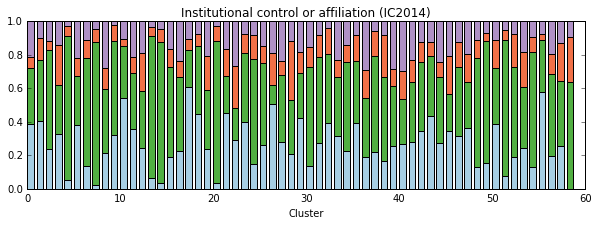

In [26]:
vaildation_mod.cluster_profiling(ds, lab, ds.columns[9])

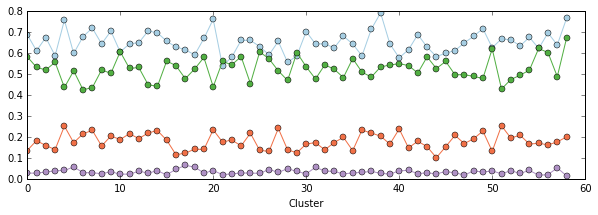

In [27]:
vaildation_mod.cluster_profiling(ds, lab, ds.columns[25], ds.columns[35], ds.columns[29], ds.columns[26])

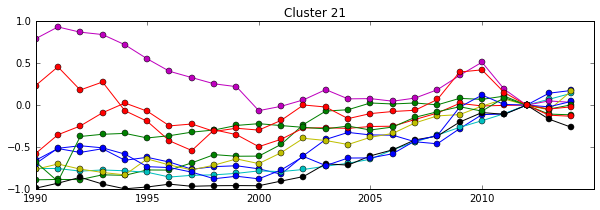

In [28]:
p.draw_cluster_trend(21, 10, schools)

In [29]:
# school lookup
p.ds_c[np.where(p.ds.columns == schools[schools['Institution Name'] == "Princeton University"]['UnitId'].values[0])]

array([21], dtype=int64)